# Using a Virtual Datacube for PREFIRE data

## Overview

Use a Kerchunk reference file for cloud-based PREFIRE satellite data analysis without downloading files.

**What You'll Work With:**

- A 12MB Kerchunk file representing ~1GB+ of satellite data
- A virtual datacube that points directly to data in the NASA Earthdata Cloud
- Creating a visualization from cloud data without full downloads

## Prerequisites
- virtualizarr >= 2.0.1
- NASA Earthdata account ([sign up here](https://urs.earthdata.nasa.gov/users/new))

## Virtual vs Traditional Approach

* **Traditional:** Download files (GB-TB) → Load into memory (or run out of memory) → Analyze 
* **Virtual:** Use lightweight reference files (MB) → Access on-demand (without downloading) → Analyze at scale

---

## 1. Setup

Configure cloud access and initialize essential libraries, including:

- **obstore**: Cloud storage access
- **virtualizarr**: Virtual dataset handling
- **xarray**: Multidimensional data handling
- **cartopy** and **matplotlib** for plotting

In [1]:
import warnings

import xarray as xr
from obstore.store import S3Store
from obstore.auth.earthdata import NasaEarthdataCredentialProvider
from virtualizarr.registry import ObjectStoreRegistry
from virtualizarr.parsers import KerchunkJSONParser

In [2]:
from packaging import version
import virtualizarr

print(f"virtualizarr version: {virtualizarr.__version__}")
if version.parse(virtualizarr.__version__) < version.parse("2.0.1"):
    raise("⚠️  This notebook requires virtualizarr >= 2.0.1. "\
          "Install with: `pip install 'virtualizarr>=2.0.1`")

virtualizarr version: 2.0.1


## 2. Configuration

In [3]:
CREDENTIALS_URL = "https://data.asdc.earthdata.nasa.gov/s3credentials"
REF_BUCKET = "asdc-prod-public"
DATA_BUCKET = "asdc-prod-protected"

REFERENCES_S3_URL = "virtual-reference-docs/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01/prefire-monthly-kerchunk_created20250819.json"

In [4]:
credential_provider = NasaEarthdataCredentialProvider(CREDENTIALS_URL)

In [5]:
# Set up ObjectStore Registry for (1) reference file and (2) data files.
S3_CONFIG = {
    "region": "us-west-2",
    "credential_provider": credential_provider,
    "virtual_hosted_style_request": False,
    "client_options": {"allow_http": True}
}

object_registry = ObjectStoreRegistry({f"s3://{REF_BUCKET}": S3Store(REF_BUCKET, **S3_CONFIG)})
object_registry.register(f"s3://{DATA_BUCKET}", store=S3Store(DATA_BUCKET, **S3_CONFIG))
print(f"✓ Registered reference and data buckets: {REF_BUCKET} and {DATA_BUCKET}")

✓ Registered reference and data buckets: asdc-prod-public and asdc-prod-protected


## 3. Load Virtual Datacube

In [6]:
warnings.filterwarnings(
    "ignore",
    message="Numcodecs codecs are not in the Zarr version 3 specification*",
    category=UserWarning
)

In [7]:
# Download and parse the JSON
json_parser = KerchunkJSONParser()
manifest_store = json_parser(
    url=f"s3://{REF_BUCKET}/{REFERENCES_S3_URL}", 
    registry=object_registry
)

CPU times: user 1.49 s, sys: 85 ms, total: 1.57 s
Wall time: 3.42 s


In [8]:
# Open the referenced data as if it were a Zarr store using xarray
data = xr.open_zarr(
    manifest_store,
    consolidated=False,
    zarr_format=3
)

data

CPU times: user 724 ms, sys: 84.2 ms, total: 809 ms
Wall time: 814 ms


<xarray.Dataset> Size: 237GB
Dimensions:                   (time: 12, xtrack: 8, spectral: 63, sfc_type: 9,
                               lat: 168, lon: 360)
Dimensions without coordinates: time, xtrack, spectral, sfc_type, lat, lon
Data variables: (12/20)
    wavelength                (time, xtrack, spectral) float32 24kB dask.array<chunksize=(1, 8, 63), meta=np.ndarray>
    idealized_wavelength      (time, xtrack, spectral) float32 24kB dask.array<chunksize=(1, 8, 63), meta=np.ndarray>
    surface_type_for_sorting  (time, sfc_type) float32 432B dask.array<chunksize=(1, 9), meta=np.ndarray>
    latitude                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 168, 360), meta=np.ndarray>
    longitude                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 168, 360), meta=np.ndarray>
    emis_mean                 (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    ...                        ...
    emis_sum                  (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    asc_emis_sum              (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    desc_emis_sum             (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    emis_sumsquares           (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    asc_emis_sumsquares       (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    desc_emis_sumsquares      (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
Attributes: (12/26)
    Conventions:                   CF-1.9
    Format:                        netCDF-4
    summary:                       The PREFIRE Level 3 products provide gridd...
    full_versionID:                R01_P00
    archival_versionID:            01
    granule_type:                  3-SFC-SORTED-ALLSKY
    ...                            ...
    UTC_coverage_end:              2024-07-31T23:59:59.969650
    additional_file_description:    
    netCDF_lib_version:            4.9.2
    orbit_sim_version:              
    SRF_NEdR_version:               
    is_this_a_final_product_file:  yes

## 4. Analyze and Visualize

Explore the virtual datacube structure and create a sample visualization of PREFIRE emissivity data.

#### 4.1. Data Overview

In [9]:
print("📊 Dataset overview:")
if 'summary' in data.attrs:
    print(f"  Description: {data.attrs['summary'][:100]}...")
print(f"  Dimensions: {dict(data.sizes)}")
print(f"  Data variables: {len(data.data_vars)}")

print("\n🔍 Key data variables:")
print(f"  • emis_mean: shape:{data.emis_mean.shape} - Surface emission data")
print(f"  • wavelength: {data.wavelength.min().values:.1f}-{data.wavelength.max().values:.1f} μm")
print(f"  • surface_type_for_sorting: {data.surface_type_for_sorting.flag_values} surface categories")
print(f"  • latitude/longitude: Geographic coordinates for each measurement")

print(f"\n⏱️  (new dimension) Time coverage: {data.sizes['time']} timesteps")

📊 Dataset overview:
  Description: The PREFIRE Level 3 products provide gridded, sorted, and/or statistical representations of other PR...
  Dimensions: {'time': 12, 'xtrack': 8, 'spectral': 63, 'sfc_type': 9, 'lat': 168, 'lon': 360}
  Data variables: 20

🔍 Key data variables:
  • emis_mean: shape:(12, 8, 9, 168, 360, 63) - Surface emission data
  • wavelength: 4.5-54.1 μm
  • surface_type_for_sorting: [1, 2, 3, 4, 5, 6, 7, 8, 9] surface categories
  • latitude/longitude: Geographic coordinates for each measurement

⏱️  (new dimension) Time coverage: 12 timesteps


### 4.2. Create visualization

We will create a visualization to demonstrate virtual datacube functionality similar to xarray usage with a standard dataset.

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

In [11]:
# projection = ccrs.PlateCarree()
projection = ccrs.Orthographic(0, 90)

def make_nice_map(axis):
    axis.add_feature(cfeature.OCEAN, color='lightblue')
    axis.add_feature(cfeature.COASTLINE, edgecolor='grey')
    axis.add_feature(cfeature.BORDERS, edgecolor="grey", linewidth=0.5)

    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True, linestyle=':')
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

In [12]:
# Extract data for plotting
time_idx, xtrack_idx, surface_idx, spectral_idx = 0, 5, 7, 5

x = data["longitude"][time_idx, :, :].squeeze()
y = data["latitude"][time_idx, :, :].squeeze()
values = data.emis_mean[time_idx, xtrack_idx, surface_idx, :, :, spectral_idx].squeeze()

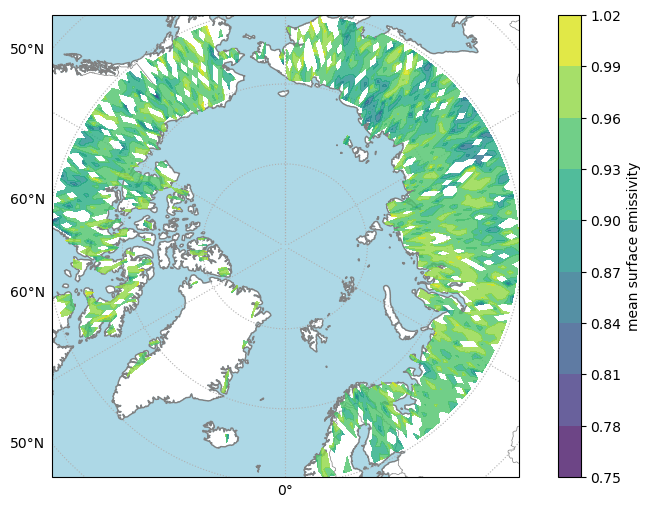

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": projection})

make_nice_map(ax)

contour_handle = ax.contourf(
    x, y, values,
    transform=ccrs.PlateCarree(),
    alpha=0.8,
    zorder=2,
)

cb = plt.colorbar(contour_handle)
cb.set_label(label_from_attrs(values))

plt.show()